In [1]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from datetime import datetime, timedelta
from src.indicators.sma import calculate_sma
from pymongo import MongoClient
import json

In [11]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [58]:
db = client["forex_data"]
collections = db.list_collection_names()
collections


['EUR_USD_H1',
 'EUR_USD_H4',
 'GBP_USD_H4',
 'EUR_GBP_D',
 'USD_JPY_H1',
 'AUD_USD_H4',
 'GBP_USD_D',
 'USD_CAD_H1',
 'USD_CAD_D',
 'USD_CAD_H4',
 'NZD_USD_H1',
 'EUR_GBP_H1',
 'AUD_USD_D',
 'EUR_USD_D',
 'NZD_USD_D',
 'GBP_JPY_D',
 'GBP_USD_H1',
 'NZD_USD_H4',
 'EUR_GBP_H4',
 'EUR_USD_M15',
 'USD_JPY_D',
 'GBP_JPY_H1',
 'GBP_JPY_H4',
 'USD_JPY_H4',
 'AUD_USD_H1']

In [29]:
# Choose a collection (for example EUR_USD_H4)
collection_name = "EUR_USD_H4"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURUSD_H4 = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURUSD_H4.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURUSD_H4["open"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["o"]))
df_EURUSD_H4["high"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["h"]))
df_EURUSD_H4["low"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["l"]))
df_EURUSD_H4["close"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURUSD_H4 = df_EURUSD_H4[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURUSD_H4)}")
print("\nFirst few rows:")
print(df_EURUSD_H4.head())


DataFrame info for EUR_USD_H4:
Total number of candles: 15547

First few rows:
                     volume     open     high      low    close
time                                                           
2015-02-15 22:00:00    3193  1.13999  1.14120  1.13893  1.14086
2015-02-16 02:00:00    1412  1.14082  1.14226  1.14030  1.14144
2015-02-16 06:00:00    3400  1.14144  1.14291  1.13955  1.14034
2015-02-16 10:00:00    2865  1.14030  1.14203  1.13969  1.14064
2015-02-16 14:00:00    4829  1.14066  1.14150  1.13408  1.13564


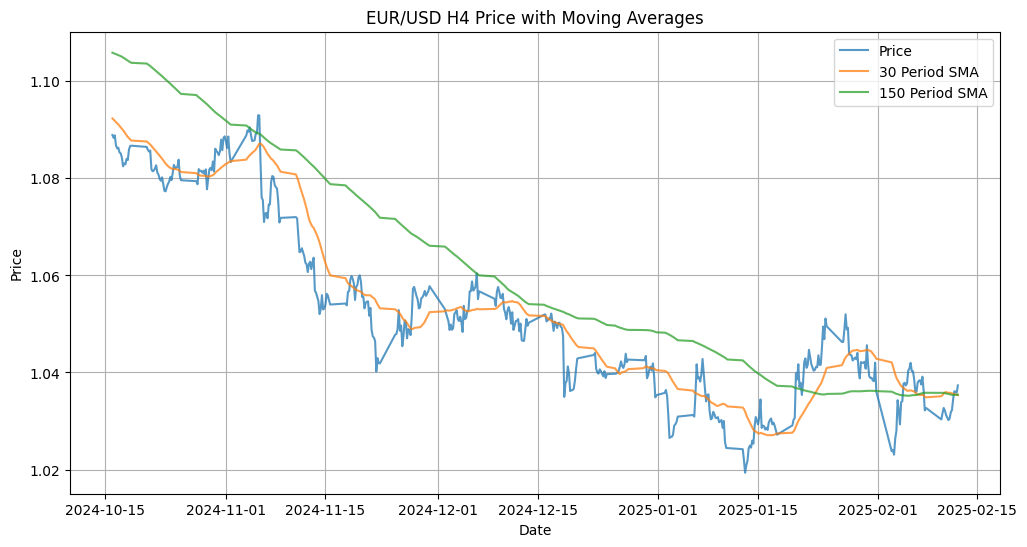

In [49]:
# Calculate moving averages
df_EURUSD_H4["SMA_30"] = calculate_sma(df_EURUSD_H4["close"], [30])[
    "sma_30"
]  # Pass period as a list
df_EURUSD_H4["SMA_150"] = calculate_sma(df_EURUSD_H4["close"], [150])[
    "sma_150"
]  # Pass period as a list

# Import plotting library
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_EURUSD_H4.index[-500:], df_EURUSD_H4["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

plt.title("EUR/USD H4 Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

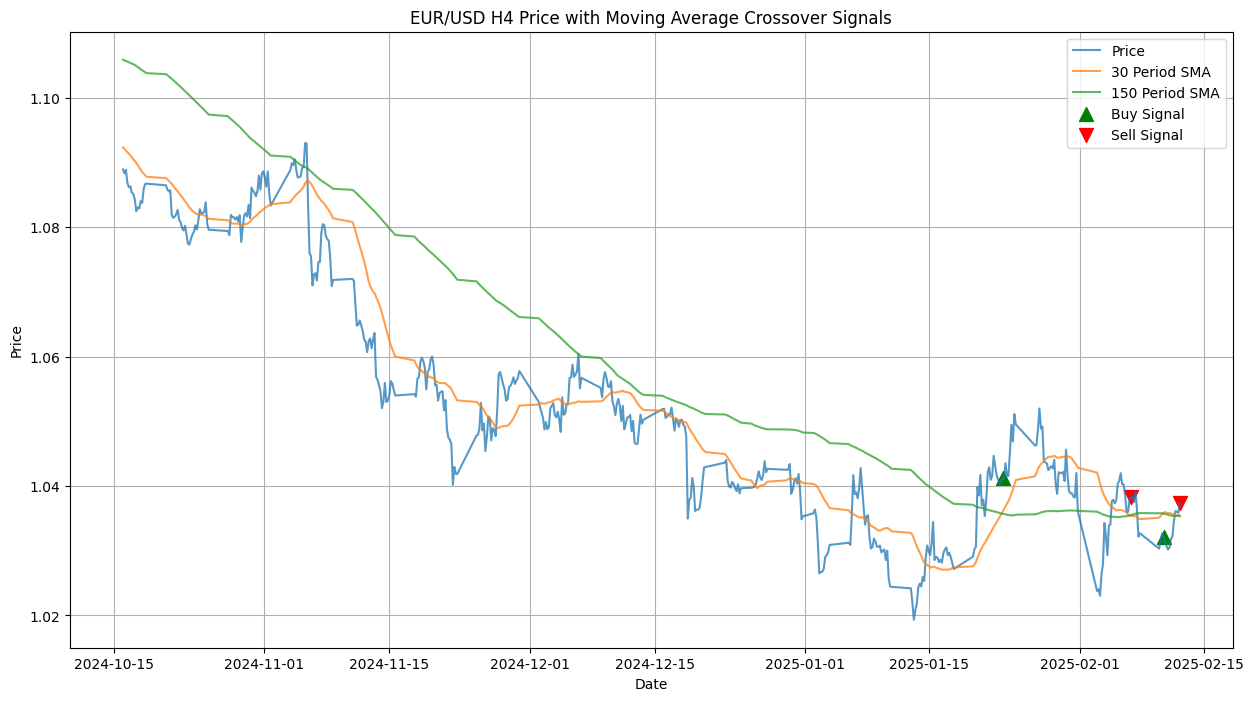


Crossover Signals:
                       close  signal
time                                
2015-03-30 01:00:00  1.08602       1
2015-03-31 09:00:00  1.07536      -1
2015-04-06 01:00:00  1.09774       1
2015-04-13 05:00:00  1.05566      -1
2015-04-28 01:00:00  1.08714       1
2015-05-25 17:00:00  1.09775      -1
2015-06-08 13:00:00  1.12330       1
2015-06-30 05:00:00  1.11414      -1
2015-07-31 09:00:00  1.10554       1
2015-08-03 13:00:00  1.09604      -1
2015-08-12 13:00:00  1.11752       1
2015-09-09 05:00:00  1.11939      -1
2015-09-11 13:00:00  1.13448       1
2015-09-23 09:00:00  1.11316      -1
2015-10-08 13:00:00  1.12823       1
2015-10-25 21:00:00  1.10211      -1
2015-12-07 14:00:00  1.08512       1
2016-01-06 02:00:00  1.07448      -1
2016-01-20 06:00:00  1.09235       1
2016-01-22 18:00:00  1.07983      -1
2016-02-01 14:00:00  1.08910       1
2016-02-25 10:00:00  1.10106      -1
2016-03-15 01:00:00  1.11073       1
2016-04-25 13:00:00  1.12661      -1
2016-05-02 01:00:0

In [51]:
import numpy as np

def identify_ma_crossovers(df, fast_col="SMA_30", slow_col="SMA_150"):
    """
    Identify MA crossover signals
    Returns DataFrame with signals: 1 for buy, -1 for sell, 0 for no signal
    """
    # Initialize signal column
    df["signal"] = 0

    # Create crossover signals
    df["signal"] = np.where(
        (df[fast_col] > df[slow_col])
        & (df[fast_col].shift(1) <= df[slow_col].shift(1)),
        1,  # Buy signal
        np.where(
            (df[fast_col] < df[slow_col])
            & (df[fast_col].shift(1) >= df[slow_col].shift(1)),
            -1,  # Sell signal
            0,  # No signal
        ),
    )

    return df


# Apply the crossover strategy
df_EURUSD_H4 = identify_ma_crossovers(df_EURUSD_H4)

# Plot with signals
plt.figure(figsize=(15, 8))

# Plot price and MAs
plt.plot(
    df_EURUSD_H4.index[-500:], df_EURUSD_H4["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

# Plot buy signals
plt.scatter(
    df_EURUSD_H4.index[-500:][df_EURUSD_H4["signal"][-500:] == 1],
    df_EURUSD_H4["close"][-500:][df_EURUSD_H4["signal"][-500:] == 1],
    marker="^",
    color="green",
    s=100,
    label="Buy Signal",
)

# Plot sell signals
plt.scatter(
    df_EURUSD_H4.index[-500:][df_EURUSD_H4["signal"][-500:] == -1],
    df_EURUSD_H4["close"][-500:][df_EURUSD_H4["signal"][-500:] == -1],
    marker="v",
    color="red",
    s=100,
    label="Sell Signal",
)

plt.title("EUR/USD H4 Price with Moving Average Crossover Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print recent signals
signals = df_EURUSD_H4[df_EURUSD_H4["signal"] != 0]
print("\nCrossover Signals:")
print(signals[["close", "signal"]].to_string())

In [53]:
def backtest_signals(df):
    """
    Backtest trades based on MA crossover signals.

    The strategy:
    - Enter a trade at the close on a signal candle (1 for buy, -1 for sell).
    - Exit when the signal reverses (from buy to sell or sell to buy).
    - If a trade is open at the end of the data, exit at the final candle's close.

    Returns a list of trades with entry/exit times & prices, and the pip gain.
    """
    trades = []
    open_trade = None

    # Ensure the DataFrame is sorted by time
    df = df.sort_index()

    for time, row in df.iterrows():
        signal = row["signal"]
        price = row["close"]

        # If there is a signal (non-zero)
        if signal != 0:
            # If no trade is open, open one
            if open_trade is None:
                open_trade = {
                    "entry_time": time,
                    "entry_price": price,
                    "signal": signal,
                }
            # If a trade is already open and the new signal is different (a reversal)
            elif signal != open_trade["signal"]:
                exit_price = price
                exit_time = time
                if open_trade["signal"] == 1:  # Buy trade
                    pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                else:  # Sell trade
                    pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                trade = {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": exit_time,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                }
                trades.append(trade)
                # Open a new trade with the current signal
                open_trade = {
                    "entry_time": time,
                    "entry_price": price,
                    "signal": signal,
                }

    # If a trade is still open at the end, close it at the last available candle
    if open_trade is not None:
        last_time = df.index[-1]
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            pip_gain = (open_trade["entry_price"] - last_price) * 10000
        trade = {
            "entry_time": open_trade["entry_time"],
            "exit_time": last_time,
            "entry_price": open_trade["entry_price"],
            "exit_price": last_price,
            "signal": open_trade["signal"],
            "pip_gain": pip_gain,
        }
        trades.append(trade)

    return trades


# Run the backtest on the DataFrame with crossover signals
trade_results = backtest_signals(df_EURUSD_H4)

# Convert results to a DataFrame for analysis
trades_df = pd.DataFrame(trade_results)
print("\nBacktest Trade Results:")
print(trades_df)

# Optionally, summarize overall performance
if not trades_df.empty:
    total_pips = trades_df["pip_gain"].sum()
    num_trades = len(trades_df)
    avg_pips = trades_df["pip_gain"].mean()
    print(f"\nTotal trades: {num_trades}")
    print(f"Total pip gain: {total_pips:.1f} pips")
    print(f"Average pip gain per trade: {avg_pips:.1f} pips")


Backtest Trade Results:
             entry_time           exit_time  entry_price  exit_price  signal  \
0   2015-03-30 01:00:00 2015-03-31 09:00:00      1.08602     1.07536     1.0   
1   2015-03-31 09:00:00 2015-04-06 01:00:00      1.07536     1.09774    -1.0   
2   2015-04-06 01:00:00 2015-04-13 05:00:00      1.09774     1.05566     1.0   
3   2015-04-13 05:00:00 2015-04-28 01:00:00      1.05566     1.08714    -1.0   
4   2015-04-28 01:00:00 2015-05-25 17:00:00      1.08714     1.09775     1.0   
..                  ...                 ...          ...         ...     ...   
147 2024-10-04 01:00:00 2025-01-23 06:00:00      1.10278     1.04117    -1.0   
148 2025-01-23 06:00:00 2025-02-06 18:00:00      1.04117     1.03830     1.0   
149 2025-02-06 18:00:00 2025-02-10 10:00:00      1.03830     1.03216    -1.0   
150 2025-02-10 10:00:00 2025-02-12 06:00:00      1.03216     1.03734     1.0   
151 2025-02-12 06:00:00 2025-02-12 06:00:00      1.03734     1.03734    -1.0   

     pip_gain 

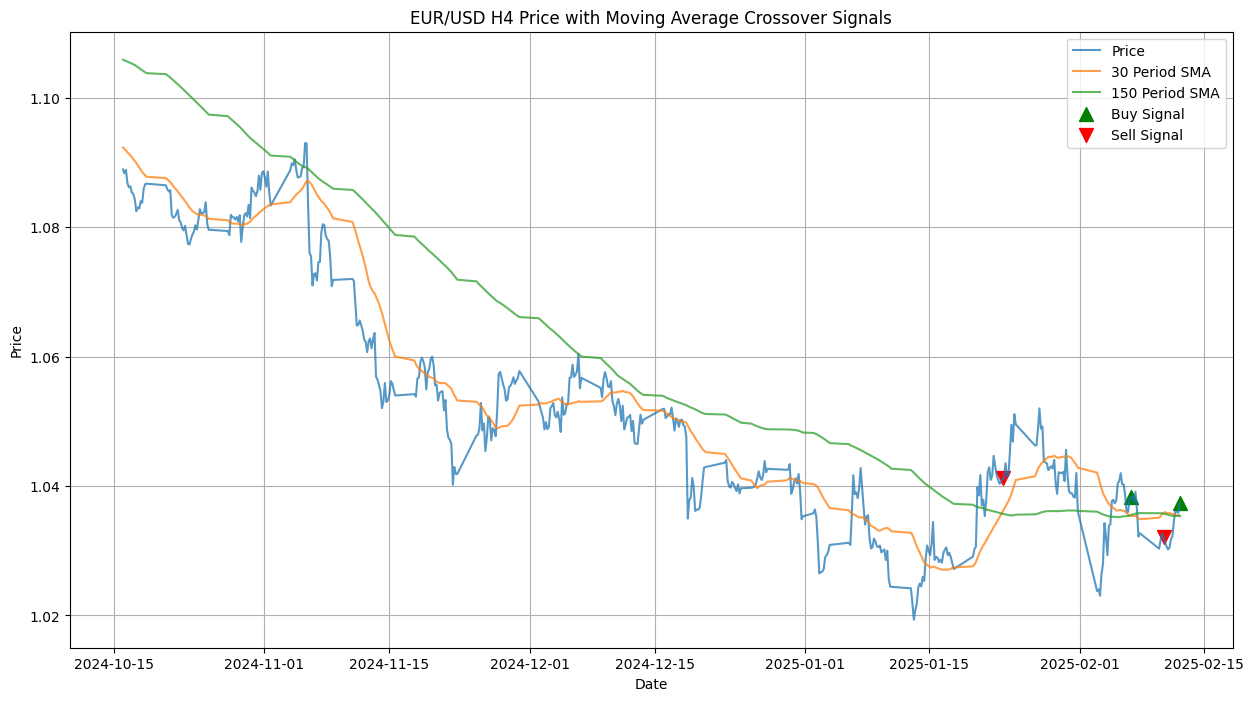


Crossover Signals:
                       close  signal
time                                
2015-03-30 01:00:00  1.08602      -1
2015-03-31 09:00:00  1.07536       1
2015-04-06 01:00:00  1.09774      -1
2015-04-13 05:00:00  1.05566       1
2015-04-28 01:00:00  1.08714      -1
2015-05-25 17:00:00  1.09775       1
2015-06-08 13:00:00  1.12330      -1
2015-06-30 05:00:00  1.11414       1
2015-07-31 09:00:00  1.10554      -1
2015-08-03 13:00:00  1.09604       1
2015-08-12 13:00:00  1.11752      -1
2015-09-09 05:00:00  1.11939       1
2015-09-11 13:00:00  1.13448      -1
2015-09-23 09:00:00  1.11316       1
2015-10-08 13:00:00  1.12823      -1
2015-10-25 21:00:00  1.10211       1
2015-12-07 14:00:00  1.08512      -1
2016-01-06 02:00:00  1.07448       1
2016-01-20 06:00:00  1.09235      -1
2016-01-22 18:00:00  1.07983       1
2016-02-01 14:00:00  1.08910      -1
2016-02-25 10:00:00  1.10106       1
2016-03-15 01:00:00  1.11073      -1
2016-04-25 13:00:00  1.12661       1
2016-05-02 01:00:0

In [ ]:
import numpy as np

# Inverse crossover strategy 30/150

def identify_ma_crossovers_inverse(df, fast_col="SMA_150", slow_col="SMA_30"):
    """
    Identify MA crossover signals
    Returns DataFrame with signals: 1 for buy, -1 for sell, 0 for no signal
    """
    # Initialize signal column
    df["signal"] = 0

    # Create crossover signals
    df["signal"] = np.where(
        (df[fast_col] > df[slow_col])
        & (df[fast_col].shift(1) <= df[slow_col].shift(1)),
        1,  # Buy signal
        np.where(
            (df[fast_col] < df[slow_col])
            & (df[fast_col].shift(1) >= df[slow_col].shift(1)),
            -1,  # Sell signal
            0,  # No signal
        ),
    )

    return df


# Apply the crossover strategy
df_EURUSD_H4 = identify_ma_crossovers_inverse(df_EURUSD_H4)

# Plot with signals
plt.figure(figsize=(15, 8))

# Plot price and MAs
plt.plot(
    df_EURUSD_H4.index[-500:], df_EURUSD_H4["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H4.index[-500:],
    df_EURUSD_H4["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

# Plot buy signals
plt.scatter(
    df_EURUSD_H4.index[-500:][df_EURUSD_H4["signal"][-500:] == 1],
    df_EURUSD_H4["close"][-500:][df_EURUSD_H4["signal"][-500:] == 1],
    marker="^",
    color="green",
    s=100,
    label="Buy Signal",
)

# Plot sell signals
plt.scatter(
    df_EURUSD_H4.index[-500:][df_EURUSD_H4["signal"][-500:] == -1],
    df_EURUSD_H4["close"][-500:][df_EURUSD_H4["signal"][-500:] == -1],
    marker="v",
    color="red",
    s=100,
    label="Sell Signal",
)

plt.title("EUR/USD H4 Price with Moving Average Crossover Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Print recent signals
signals = df_EURUSD_H4[df_EURUSD_H4["signal"] != 0]
print("\nCrossover Signals:")
print(signals[["close", "signal"]].to_string())

In [60]:
def backtest_signals(df):
    """
    Backtest trades based on MA crossover signals.

    The strategy:
    - Enter a trade at the close on a signal candle (1 for buy, -1 for sell).
    - Exit when the signal reverses (from buy to sell or sell to buy).
    - If a trade is open at the end of the data, exit at the final candle's close.

    Returns a list of trades with entry/exit times & prices, and the pip gain.
    """
    trades = []
    open_trade = None

    # Ensure the DataFrame is sorted by time
    df = df.sort_index()

    for time, row in df.iterrows():
        signal = row["signal"]
        price = row["close"]

        # If there is a signal (non-zero)
        if signal != 0:
            # If no trade is open, open one
            if open_trade is None:
                open_trade = {
                    "entry_time": time,
                    "entry_price": price,
                    "signal": signal,
                }
            # If a trade is already open and the new signal is different (a reversal)
            elif signal != open_trade["signal"]:
                exit_price = price
                exit_time = time
                if open_trade["signal"] == 1:  # Buy trade
                    pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                else:  # Sell trade
                    pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                trade = {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": exit_time,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                }
                trades.append(trade)
                # Open a new trade with the current signal
                open_trade = {
                    "entry_time": time,
                    "entry_price": price,
                    "signal": signal,
                }

    # If a trade is still open at the end, close it at the last available candle
    if open_trade is not None:
        last_time = df.index[-1]
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            pip_gain = (open_trade["entry_price"] - last_price) * 10000
        trade = {
            "entry_time": open_trade["entry_time"],
            "exit_time": last_time,
            "entry_price": open_trade["entry_price"],
            "exit_price": last_price,
            "signal": open_trade["signal"],
            "pip_gain": pip_gain,
        }
        trades.append(trade)

    return trades


# Run the backtest on the DataFrame with crossover signals
trade_results = backtest_signals(df_EURUSD_H4)

# Convert results to a DataFrame for analysis
trades_df = pd.DataFrame(trade_results)
print("\nBacktest Trade Results:")
print(trades_df)

# Optionally, summarize overall performance
if not trades_df.empty:
    total_pips = trades_df["pip_gain"].sum()
    num_trades = len(trades_df)
    avg_pips = trades_df["pip_gain"].mean()
    print(f"\nTotal trades: {num_trades}")
    print(f"Total pip gain: {total_pips:.1f} pips")
    print(f"Average pip gain per trade: {avg_pips:.1f} pips")


Backtest Trade Results:
             entry_time           exit_time  entry_price  exit_price  signal  \
0   2015-03-30 01:00:00 2015-03-31 09:00:00      1.08602     1.07536    -1.0   
1   2015-03-31 09:00:00 2015-04-06 01:00:00      1.07536     1.09774     1.0   
2   2015-04-06 01:00:00 2015-04-13 05:00:00      1.09774     1.05566    -1.0   
3   2015-04-13 05:00:00 2015-04-28 01:00:00      1.05566     1.08714     1.0   
4   2015-04-28 01:00:00 2015-05-25 17:00:00      1.08714     1.09775    -1.0   
..                  ...                 ...          ...         ...     ...   
147 2024-10-04 01:00:00 2025-01-23 06:00:00      1.10278     1.04117     1.0   
148 2025-01-23 06:00:00 2025-02-06 18:00:00      1.04117     1.03830    -1.0   
149 2025-02-06 18:00:00 2025-02-10 10:00:00      1.03830     1.03216     1.0   
150 2025-02-10 10:00:00 2025-02-12 06:00:00      1.03216     1.03734    -1.0   
151 2025-02-12 06:00:00 2025-02-12 06:00:00      1.03734     1.03734     1.0   

     pip_gain 

In [62]:
def performance_metrics(trades_df):
    trades_df["winning"] = trades_df["pip_gain"] > 0
    win_rate = trades_df["winning"].mean()  # fraction of winning trades
    avg_win = (
        trades_df.loc[trades_df["pip_gain"] > 0, "pip_gain"].mean()
        if trades_df.loc[trades_df["pip_gain"] > 0].shape[0]
        else 0
    )
    avg_loss = (
        trades_df.loc[trades_df["pip_gain"] <= 0, "pip_gain"].mean()
        if trades_df.loc[trades_df["pip_gain"] <= 0].shape[0]
        else 0
    )

    # Build an equity curve from pip gains
    equity_curve = trades_df["pip_gain"].cumsum()
    running_max = equity_curve.cummax()
    drawdown = equity_curve - running_max
    max_drawdown = drawdown.min()

    return win_rate, avg_win, avg_loss, max_drawdown, equity_curve


# Assuming trades_df is already produced by your backtest:
win_rate, avg_win, avg_loss, max_drawdown, equity_curve = performance_metrics(trades_df)
print(f"Win rate: {win_rate*100:.1f}%")
print(f"Average win: {avg_win:.1f} pips")
print(f"Average loss: {avg_loss:.1f} pips")
print(f"Maximum drawdown: {max_drawdown:.1f} pips")

Win rate: 65.8%
Average win: 123.1 pips
Average loss: -178.2 pips
Maximum drawdown: -2823.4 pips


In [63]:
def backtest_with_trailing_profit_targets(df, profit_target=50, trailing_stop=20):
    """
    Backtest trades using trailing stops and profit targets.

    profit_target and trailing_stop are defined in pips.
    When a trade is open, the function checks each subsequent candle:
      - For a long trade:
          Exit if profit target is reached OR if price retraces by 'trailing_stop' from the max.
      - For a short trade:
          Exit if profit target is reached OR if price retraces by 'trailing_stop' from the min.

    If an opposite signal comes before those conditions, then exit based on the signal.
    """
    trades = []
    open_trade = None
    highest_price = None  # For long trade tracking
    lowest_price = None  # For short trade tracking

    df = df.sort_index()

    # Convert pip factors; for EUR/USD, 1 pip = 0.0001
    pip_factor = 10000

    # Use the DataFrame index ordering; loop over rows by position
    prices = df["close"].values
    signals = df["signal"].values
    times = df.index

    i = 0
    while i < len(df):
        sig = signals[i]
        price = prices[i]
        time = times[i]

        # If no trade is open and there's a signal, enter a trade.
        if open_trade is None and sig != 0:
            open_trade = {"entry_time": time, "entry_price": price, "signal": sig}
            if sig == 1:
                highest_price = price
            elif sig == -1:
                lowest_price = price
            i += 1
            continue

        # If a trade is open, iterate candle by candle to check for exit conditions.
        if open_trade is not None:
            trade_direction = open_trade["signal"]
            exit_trade = False

            # Update trailing high/low within the trade
            if trade_direction == 1:
                highest_price = max(highest_price, price)
                # Check profit target
                if (price - open_trade["entry_price"]) * pip_factor >= profit_target:
                    exit_trade = True
                # Check trailing stop: if price falls by trailing_stop from highest_price
                elif (highest_price - price) * pip_factor >= trailing_stop:
                    exit_trade = True

            elif trade_direction == -1:
                lowest_price = min(lowest_price, price)
                if (open_trade["entry_price"] - price) * pip_factor >= profit_target:
                    exit_trade = True
                elif (price - lowest_price) * pip_factor >= trailing_stop:
                    exit_trade = True

            # Also check if there's an opposite signal to force an exit
            if signals[i] != 0 and signals[i] != trade_direction:
                exit_trade = True

            if exit_trade:
                exit_time = time
                exit_price = price
                # Calculate pip gain for each trade type
                if trade_direction == 1:
                    pip_gain = (exit_price - open_trade["entry_price"]) * pip_factor
                else:
                    pip_gain = (open_trade["entry_price"] - exit_price) * pip_factor

                trade = {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": exit_time,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": trade_direction,
                    "pip_gain": pip_gain,
                }
                trades.append(trade)
                # Reset trade tracking variables
                open_trade = None
                highest_price = None
                lowest_price = None
        i += 1

    # Close any open trade at the end of the data.
    if open_trade is not None:
        last_time = times[-1]
        last_price = prices[-1]
        if open_trade["signal"] == 1:
            pip_gain = (last_price - open_trade["entry_price"]) * pip_factor
        else:
            pip_gain = (open_trade["entry_price"] - last_price) * pip_factor
        trade = {
            "entry_time": open_trade["entry_time"],
            "exit_time": last_time,
            "entry_price": open_trade["entry_price"],
            "exit_price": last_price,
            "signal": open_trade["signal"],
            "pip_gain": pip_gain,
        }
        trades.append(trade)

    return trades


# Run the enhanced backtest with trailing stops & profit targets
trade_results_enhanced = backtest_with_trailing_profit_targets(
    df_EURUSD_H4, profit_target=50, trailing_stop=20
)
trades_enhanced_df = pd.DataFrame(trade_results_enhanced)
print("\nEnhanced Backtest Trade Results:")
print(trades_enhanced_df)

# Analyze performance of the enhanced strategy
(win_rate_enh, avg_win_en, avg_loss_en, max_drawdown_en, equity_curve_en) = (
    performance_metrics(trades_enhanced_df)
)

print(f"\nEnhanced Strategy Performance:")
print(f"Total trades: {len(trades_enhanced_df)}")
print(f"Win rate: {win_rate*100:.1f}%")
print(f"Average win: {avg_win_en:.1f} pips, Average loss: {avg_loss_en:.1f} pips")
print(f"Maximum drawdown: {max_drawdown_en:.1f} pips")


Enhanced Backtest Trade Results:
             entry_time           exit_time  entry_price  exit_price  signal  \
0   2015-03-30 01:00:00 2015-03-31 01:00:00      1.08602     1.07974      -1   
1   2015-03-31 09:00:00 2015-03-31 13:00:00      1.07536     1.07282       1   
2   2015-04-06 01:00:00 2015-04-06 09:00:00      1.09774     1.10194      -1   
3   2015-04-13 05:00:00 2015-04-14 01:00:00      1.05566     1.05559       1   
4   2015-04-28 01:00:00 2015-04-28 05:00:00      1.08714     1.09041      -1   
..                  ...                 ...          ...         ...     ...   
145 2024-10-04 01:00:00 2024-10-04 09:00:00      1.10278     1.09610       1   
146 2025-01-23 06:00:00 2025-01-23 14:00:00      1.04117     1.04354      -1   
147 2025-02-06 18:00:00 2025-02-07 10:00:00      1.03830     1.03636       1   
148 2025-02-10 10:00:00 2025-02-11 10:00:00      1.03216     1.03225      -1   
149 2025-02-12 06:00:00 2025-02-12 06:00:00      1.03734     1.03734       1   

     

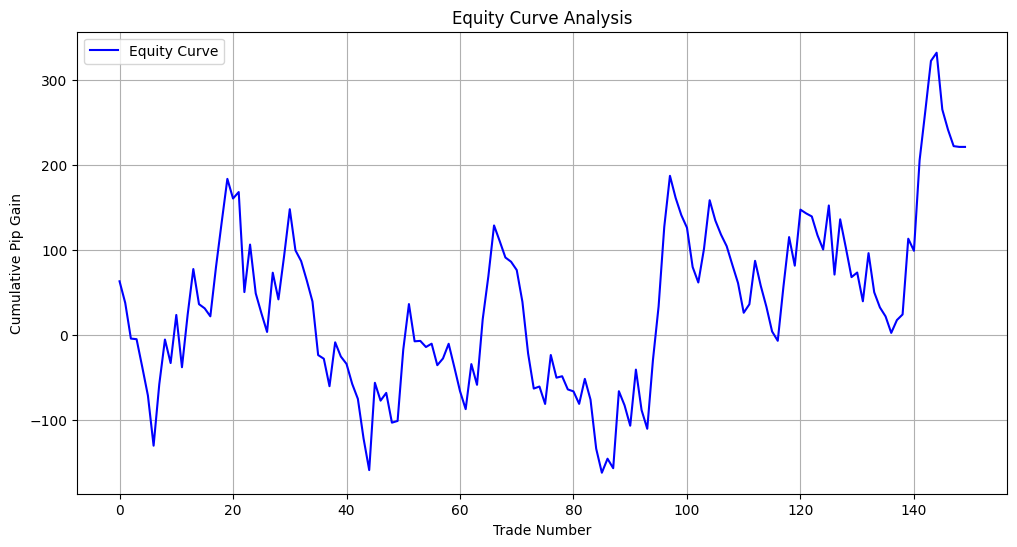

In [64]:
import matplotlib.pyplot as plt

# Assuming you already computed an equity curve from performance_metrics, e.g.:
# equity_curve = trades_df["pip_gain"].cumsum()
# If you haven't, you can compute it like:
equity_curve = trades_enhanced_df["pip_gain"].cumsum()

plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve, label="Equity Curve", color="blue")
plt.title("Equity Curve Analysis")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Pip Gain")
plt.grid(True)
plt.legend()
plt.show()

In [66]:
# Assume trades_enhanced_df is the DataFrame with your enhanced backtest trades,
# and it contains a column 'pip_gain' for each trade.

initial_balance = 10000.0
balance = initial_balance
balances = []  # To track balance after each trade
trade_balances = []  # For plotting later, if needed

# Set constants:
risk_percent = 0.01  # 1% risk per trade
risk_pips = 20  # predetermined risk in pips (trailing stop parameter)
pip_value_per_standard_lot = 20  # $10 per pip for 1 standard lot

for index, row in trades_enhanced_df.iterrows():
    risk_dollars = balance * risk_percent
    # Position size in standard lots:
    position_size = risk_dollars / (risk_pips * pip_value_per_standard_lot)
    # Dollar change for the trade:
    # For each pip gain, gain $ (position_size * pip_value_per_standard_lot)
    dollar_change = row["pip_gain"] * position_size * pip_value_per_standard_lot
    balance += dollar_change
    balances.append(balance)
    trade_balances.append(
        {
            "trade_index": index,
            "balance": balance,
            "dollar_change": dollar_change,
            "pip_gain": row["pip_gain"],
        }
    )

print(f"Initial Balance: ${initial_balance:,.2f}")
print(f"Final Balance: ${balance:,.2f}")

Initial Balance: $10,000.00
Final Balance: $10,785.75
